## Imports

In [9]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd 

sys.path.append('/sise/home/ezradin/pred-sentencing/src/utils')

from files import load_json, save_json


labels_map = {
        "CONFESSION": "Confession",
        'HELD_WAY': 'Held\nWay',        
        "OBTAIN_WAY": "Obtain\nWay",
        "PURPOSE": "Purpose",
        'STATUS_WEP': 'Status\nWeapon',
        "TYPE_WEP": 'Weapon\nType',
        "USE": "Use"
    }

/home/ezradin/.conda/envs/trans_up/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot fucntions

In [10]:
def plot_auc_pr_comparison(title, xlabel, ylabel, methods_dict, save_path=None):
    """
    Plot AUC PR comparison between multiple methods across different labels and save the plot to a file.

    Parameters:
    title (str): Title of the plot
    xlabel (str): Label for the x-axis
    ylabel (str): Label for the y-axis
    methods_dict (dict): Dictionary where keys are method names and values are dictionaries with labels as keys and AUC PR scores as values
    save_path (str): Path to save the plot image
    """
    
    avg_scores = {method: np.mean(list(scores.values())) for method, scores in methods_dict.items()}
    best_model = max(avg_scores, key=avg_scores.get)
    sorted_labels = sorted(methods_dict[best_model], key=methods_dict[best_model].get, reverse=True)


    labels = list(next(iter(methods_dict.values())).keys())
    num_methods = len(methods_dict)
    width = 0.12  # width of the bars (reduced to create space between bars)

    fig, ax = plt.subplots()
    indices = np.arange(len(sorted_labels))  # the label locations

    for i, (method, scores) in enumerate(methods_dict.items()):
        sorted_values = [scores[label] for label in sorted_labels]  # Keep the original label order
        offset = width * i
        ax.bar(indices + offset, sorted_values, width, label=method, alpha=0.75)

    # Add grid for better readability
    ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.set_xticks(indices + width * (num_methods - 1) / 2)
    ax.set_xticklabels(sorted_labels, rotation=25, ha='right')  # Slant the labels and align to the right
    ax.legend(loc='best')
    
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

    
def plot_radar_chart(data, save_path=None):
    """Generates and saves a radar chart comparing PR-AUC metrics for different models across several labels."""
    
    # Mapping original keys to real label names
    label_map = {
        "CONFESSION": "Confession",
        'CIRCUM_OFFENSE': 'Circumstances\n Offense',        
        "GENERAL_CIRCUM": "General\n Circumstances",
        "PUNISHMENT": "Punishment",
        'reject': 'Reject'
    }

    labels = list(label_map.values())
    
    models = {model: [values[key] for key in label_map.keys()] for model, values in data.items()}
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for model, values in models.items():
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    # Add circular grid labels at 0.2, 0.4, 0.6, 0.8, 1
    ax.set_rscale('linear')
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(['', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0'], fontsize=10)
    
    # Adjust label position and increase figure size for better spacing
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, ha='center')
    ax.set_title('Model Comparison by PR-AUC on Different Labels', size=18, weight='bold', pad=20)
    
    ax.legend(loc='best', bbox_to_anchor=(1.1, 1.1), fontsize=10)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap_comparison(methods_dict, title, xlabel, ylabel, metric, save_path=None):
    """
    Plot heatmap of AUC PR comparison between multiple methods across different labels.

    Parameters:
    methods_dict (dict): Dictionary where keys are method names and values are dictionaries with labels as keys and AUC PR scores as values
    """
    
    new_dict = defaultdict(dict)
    # Convert the dictionary to a DataFrame
    for model_key, values_dict in methods_dict.items():
        for original_key, metric_values in values_dict.items():
            model_key = model_key.replace(' ', '\n')
            new_dict[model_key][labels_map[original_key]] = metric_values
        
    df = pd.DataFrame(new_dict).T  # Transpose so models are rows, labels are columns
    df['average'] = df.mean(axis=1)
    df = df.sort_values(by='average', ascending=False)
    df = df.drop(columns='average')
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlGnBu", cbar_kws={'label': metric})
    
    plt.title(title,  size=18, weight='bold', pad=20)
    plt.xlabel(xlabel, weight='bold')
    plt.ylabel(ylabel, weight='bold')
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


def plot_dice_comparison_lines(title, xlabel, ylabel, methods_dict, save_path=None):
    """
    Plot AUC PR comparison using line plots, sorted by the model with the highest average performance.
    Also applies label mapping as per the provided labels_map.
    
    Parameters:
    - title (str): Title of the plot
    - xlabel (str): Label for the x-axis
    - ylabel (str): Label for the y-axis
    - methods_dict (dict): Dictionary where keys are method names and values are dictionaries with labels as keys and AUC PR scores as values
    - labels_map (dict): Dictionary mapping original labels to their display names.
    - save_path (str, optional): Path to save the plot image
    """
    
    # Calculate the average performance for each model
    avg_scores = {method: np.mean(list(scores.values())) for method, scores in methods_dict.items()}
    
    # Find the model with the highest average score
    best_model = max(avg_scores, key=avg_scores.get)
    
    # Sort labels based on the values of the best model
    sorted_labels = sorted(methods_dict[best_model], key=methods_dict[best_model].get, reverse=True)

    # Apply label mapping to the sorted labels
    sorted_labels_mapped = [labels_map.get(label, label) for label in sorted_labels]

    fig, ax = plt.subplots()

    for method, scores in methods_dict.items():
        sorted_values = [scores[label] for label in sorted_labels]
        ax.plot(sorted_labels_mapped, sorted_values, marker='o', label=method)

    # Set labels, title, and legend
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='best')
    
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

## Load result



In [4]:
def arrange_dictionary(result_dict):
    
    common_keys = set.intersection(*(set(inner_dict.keys()) for inner_dict in result_dict.values()))
    for key in result_dict:
        result_dict[key] = {k: v for k, v in result_dict[key].items() if k in common_keys}
    
    return result_dict

### Sentence Classification

In [7]:
def load_result(data_path, experiment_type, result_dict=None):
    """
    This function loads the experiment results from the given path, based on the experiment type 
    (language model or general), and stores the metric results in a dictionary structure.
    """
    for label_dir in os.listdir(data_path):
        if 'yaml' in label_dir:
            continue
        
        try:
            if experiment_type == 'language_model':
                for language_model in os.listdir(os.path.join(data_path, label_dir)):
                    for sub_language_model in os.listdir(os.path.join(data_path, label_dir, language_model)):
                        metric_data = load_json(os.path.join(data_path, label_dir, language_model, sub_language_model, 'metric.json'))
                        label_name = label_dir.replace('CIR_', '')
                        if label_name == '_HELD_WAY_WEP':
                            label_name = 'HELD_WAY'
                        experiment_key = sub_language_model
                        if sub_language_model == 'bert-multilingual-passage-reranking-msmarco':
                            experiment_key = 'multilingual'
                        result_dict[experiment_key][label_name] = metric_data['PRAUC']
                        
            else:  # General or other specific experiment types
                metric_data = load_json(os.path.join(data_path, label_dir, 'metric.json'))
                label_name = label_dir.replace('CIR_', '')
                if label_name == '_HELD_WAY_WEP':
                    label_name = 'HELD_WAY'
                result_dict[experiment_type][label_name] = metric_data['PRAUC']
        except Exception as e:
            print(f"Error processing {label_dir}: {e}")
            continue
        
    return result_dict

def load_few_results(path_list):
    result_dict = defaultdict(dict)
    for data_path, experement_name in path_list:
        result_dict = load_result(data_path=data_path, experiment_type=experement_name, result_dict=result_dict)
        
    result_dict = arrange_dictionary(result_dict)
    return result_dict

In [ ]:
language_model_path = '/home/ezradin/pred-sentencing/results/evaluations/sentence_calssification/08_24_language_model'
result_dict = defaultdict(dict)

result_dict = load_result(language_model_path,  
                          experiment_type='language_model',
                          result_dict=result_dict)


data_list = [('/home/ezradin/pred-sentencing/results/evaluations/sentence_calssification/08_30_12cases_10epoch','10 epoch'),
            ('/home/ezradin/pred-sentencing/results/evaluations/sentence_calssification/08_31_just_first_level_1epoch', '1 epoch')]


result_dict = load_few_results(data_list)


### Feature Extraction

In [55]:
def load_result_from_csv(csv_file_path, result_dict=None):
    """
    This function loads and processes experiment results from CSV files
    and stores the metric results in a dictionary structure.
    """
    if result_dict is None:
        result_dict = defaultdict(dict)
    
    try:
        # Load CSV file
        csv_data = pd.read_csv(csv_file_path)
        for index, row in csv_data.iterrows():
            label_name = row['feature']
            prauc_value = row['Dice score']
            result_dict[label_name] = prauc_value
    
    except Exception as e:
        print(f"Error processing CSV file {csv_file_path}: {e}")
    
    return result_dict

def load_result_from_txt(txt_file_path, result_dict=None):
    """
    This function loads and processes experiment results from text files
    and stores the metric results in a dictionary structure.
    """
    if result_dict is None:
        result_dict = defaultdict(dict)
    
    try:
        # Load TXT file
        with open(txt_file_path, 'r') as txt_file:
            for line in txt_file:
                if "Mean Dice coefficient for:" in line:
                    continue
                try:
                    label, value = line.split(':')
                    label_name = label.strip()
                    dice_value = float(value.strip())
                    result_dict[label_name] = dice_value
                except ValueError:
                    print(f"Error processing line in TXT file {txt_file_path}: {line}")
                    continue
    
    except Exception as e:
        print(f"Error processing TXT file {txt_file_path}: {e}")
    
    return result_dict

def load_few_results_from_directory(directory_path):
    """
    This function loads results from CSV and TXT files located in various subdirectories.
    It processes each type of file (CSV or TXT) separately and updates the result_dict.
    The directories (dirs) will be used as keys in the result_dict.
    """
    result_dict = defaultdict(lambda: defaultdict(dict))
    
    # Traverse the directory to find CSV and TXT files
    for root, dirs, files in os.walk(directory_path):
        current_dir = os.path.basename(root)  # Get the name of the current directory
        for file in files:
            if file.startswith('res') and file.endswith('.csv'):
                csv_file_path = os.path.join(root, file)
                result_dict[current_dir] = load_result_from_csv(csv_file_path, result_dict[current_dir])
            elif file.startswith('res') and file.endswith('.txt'):
                txt_file_path = os.path.join(root, file)
                result_dict[current_dir] = load_result_from_txt(txt_file_path, result_dict[current_dir])
    result_dict = arrange_dictionary(result_dict)
    return result_dict

# Example usage
## difference LLM
# directory_path = '/home/ezradin/pred-sentencing/results/evaluations/feature_extraction/diff_models'  # Path to the directory containing subdirectories with the 'res' files
# result_dict = load_few_results_from_directory(directory_path)


{'Classified Sentences': defaultdict(dict,
             {'CONFESSION': 0.608,
              'OBTAIN_WAY': 0.684,
              'STATUS_WEP': 0.303,
              'HELD_WAY': 0.655,
              'PURPOSE': 0.61,
              'USE': 0.692,
              'TYPE_WEP': 0.716}),
 'Tagged Sentences': defaultdict(dict,
             {'CONFESSION': 0.921,
              'OBTAIN_WAY': 0.7,
              'STATUS_WEP': 0.4,
              'HELD_WAY': 0.715,
              'PURPOSE': 0.667,
              'USE': 0.939,
              'TYPE_WEP': 0.749})}

### Case Similarity

In [5]:
def parse_model_evaluation(file_path, result):
    file_name = file_path.split('/')[-2].replace('_',' ')
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    metrics = {}
    for i, line in enumerate(lines):
        if "Accuracy" in line:
            metrics['Accuracy'] = float(line.split(":")[1].strip())
        elif "Precision" in line:
            metrics['Precision'] = float(line.split(":")[1].strip())
        elif "Recall" in line:
            metrics['Recall'] = float(line.split(":")[1].strip())
        elif "F1" in line:
            metrics['F1'] = float(line.split(":")[1].strip())
            
        elif "Confusion Matrix" in line:
            # Extracting the confusion matrix (next two lines after 'Confusion Matrix')
            cm_line1 = lines[i+1].strip().replace('[', '').replace(']', '')  # Remove brackets
            cm_line2 = lines[i+2].strip().replace('[', '').replace(']', '')  # Remove brackets
            
            # Convert the matrix from string to integers
            row1 = list(map(int, cm_line1.split()))
            row2 = list(map(int, cm_line2.split()))
            confusion_matrix = [row1, row2]
            
            # Calculate FPR: FP / (FP + TN)
            FP = row1[1]
            TN = row1[0]
            metrics['FPR'] = round(FP / (FP + TN) if (FP + TN) != 0 else 0, 3)
            
        elif "AUC Score" in line:
            continue
            
    result[file_name] = metrics
    return result



In [25]:
for key in result_dict.keys():result_dict[key].pop('FPR')

In [7]:
result_dict = {}
# Example file path
model_fe_path = '/home/ezradin/pred-sentencing/results/evaluations/case_similarity/2024-09-09_sonnet_fe/Model Features/Claude FE_report.txt'
# rf_path = '/home/ezradin/pred-sentencing/results/evaluations/case_similarity/2024-09-07_model_fe/Random Forest_report.txt'
manual_fe_path = '/home/ezradin/pred-sentencing/results/evaluations/case_similarity/2024-09-09_manual_tagging_claude/Manual Features/Manual FE_report.txt'
# lg = '/home/ezradin/pred-sentencing/results/evaluations/case_similarity/2024-09-16_ml_models/logistic_regression/evaluation_report.txt'
# svm = '/home/ezradin/pred-sentencing/results/evaluations/case_similarity/2024-09-16_ml_models/svm/evaluation_report.txt'
# dt = '/home/ezradin/pred-sentencing/results/evaluations/case_similarity/2024-09-16_ml_models/decision_tree/evaluation_report.txt'

# Call the function
# result_dict = parse_model_evaluation(manual_path, result_dict)
result_dict = parse_model_evaluation(model_fe_path, result_dict)
result_dict = parse_model_evaluation(manual_fe_path, result_dict)
# result_dict = parse_model_evaluation(dt, result_dict)

# result_dict = parse_model_evaluation(lg, result_dict)
# result_dict = parse_model_evaluation(svm, result_dict)


result_dict


{'Model Features': {'Accuracy': 0.673,
  'Precision': 0.675,
  'Recall': 0.673,
  'F1': 0.674,
  'FPR': 0.301},
 'Manual Features': {'Accuracy': 0.696,
  'Precision': 0.783,
  'Recall': 0.696,
  'F1': 0.65,
  'FPR': 0.012}}

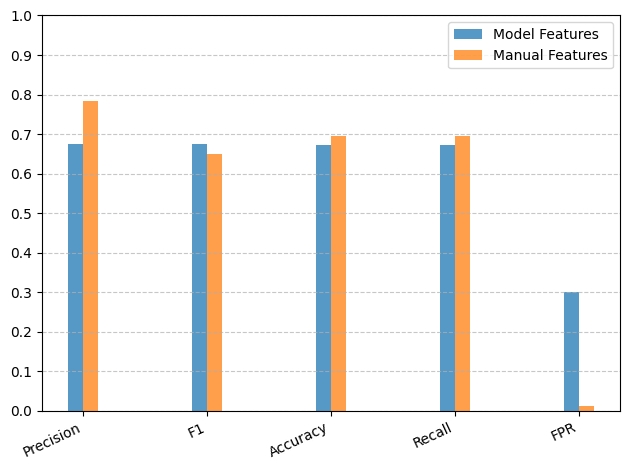

In [11]:
plot_auc_pr_comparison('' , '', '', result_dict)

## Plots

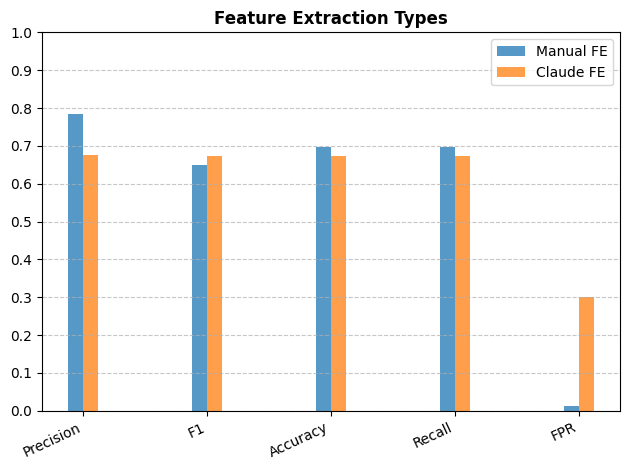

In [12]:
plot_auc_pr_comparison('Feature Extraction Types' , '', '', result_dict, '/home/ezradin/pred-sentencing/results/evaluations/case_similarity')

### Sentence Classification

In [ ]:
plot_radar_chart(result_dict)

In [ ]:
save_path='/home/ezradin/pred-sentencing/results/analysis_plots/sentence_classification'
plot_auc_pr_comparison('Largest trein set' , 'labels', 'PR-AUC', result_dict)

In [11]:
save_json(result_dict, 'diff_lang.json')

### Feature Extraction

#### Pipeline Evaluation


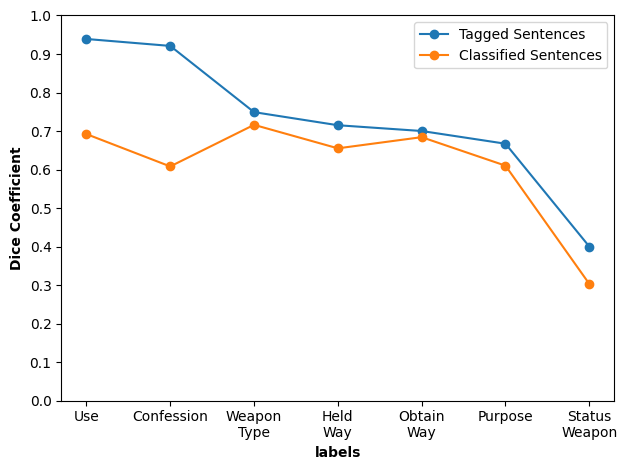

In [73]:
result_dict = {}
result_dict['Tagged Sentences'] = load_result_from_txt('/home/ezradin/pred-sentencing/results/evaluations/feature_extraction/diff_models/Dicta2.0/res_manual_feature_extraction_error_analysis_17.6.txt')
result_dict['Classified Sentences'] = load_result_from_txt('/home/ezradin/pred-sentencing/results/evaluations/feature_extraction/pipeline_eval/dicta2_07_09.txt')
result_dict
save_path = '/home/ezradin/pred-sentencing/results/evaluations/feature_extraction/pipeline_eval'
plot_dice_comparison_lines('' , 'labels', 'Dice Coefficient', result_dict,save_path=save_path)

#### Language Models Comparison

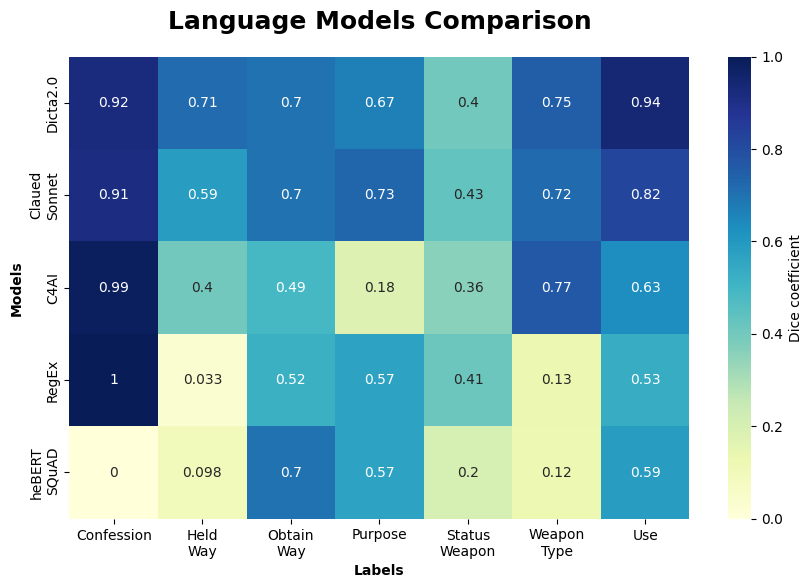

In [46]:
# Example usage
save_path = '/home/ezradin/pred-sentencing/results/evaluations/feature_extraction/diff_models'
plot_heatmap_comparison(result_dict, title="Language Models Comparison",save_path=save_path, metric='Dice coefficient', xlabel="Labels", ylabel="Models")